In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torch.nn.functional as F

from quantum_models import QuanvolutionModel

import medmnist
from medmnist import BreastMNIST
from medmnist import INFO, Evaluator

import pennylane as qml

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

ImportError: cannot import name 'QuanvolutionModel' from 'quantum_models' (/home/eflammere/QuantumIC/Quantum/notebooks/quantum_models.py)

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print(f"Using: {torch.cuda.get_device_name(0)}")
    print(f"CUDA: {torch.version.cuda}")
else:
    print("CUDA is not available. Using CPU.")

Using: NVIDIA GeForce RTX 4070 Ti SUPER
CUDA: 12.4


In [41]:
info = INFO['breastmnist']
data_flag = 'breastmnist'
DataClass = BreastMNIST

task = info['task']  
n_channels = info['n_channels']
n_classes = len(info['label'])

print(f"Number of classes:", n_classes)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5]),
    lambda x: x.unsqueeze(0) 
])

Number of classes: 2


### **Dataset Configuration for 28x28 and 64x64 Images**

In the following code, the dataset is configured to use images of size 28x28, which is the default setting for the BreastMNIST dataset (and other similar datasets like MedMNIST). 

In [42]:
data_train28 = DataClass(split='train', transform=transform, download=True)
data_test28 = DataClass(split='test', transform=transform, download=True)
data_eval28 = DataClass(split='val', transform=transform, download=True)

For the case where you want to use images of size 64x64, the code can be adjusted to load the dataset with this specific size by setting the `size` parameter to 64.

In [43]:
data_train64 = DataClass(split='train', transform=transform, download=True, size=64)
data_test64 = DataClass(split='test', transform=transform, download=True, size=64)
data_eval64 = DataClass(split='val', transform=transform, download=True, size=64)

Using downloaded and verified file: /home/eflammere/.medmnist/breastmnist_64.npz
Using downloaded and verified file: /home/eflammere/.medmnist/breastmnist_64.npz
Using downloaded and verified file: /home/eflammere/.medmnist/breastmnist_64.npz


The following code snippet demonstrates how to load the training, test, and validation splits of the dataset:


In [44]:
batch_size = 128  
dataloader_train = data.DataLoader(dataset=data_train64, batch_size=batch_size, shuffle=True)
dataloader_test = data.DataLoader(dataset=data_test64, batch_size=batch_size, shuffle=False)
dataloader_eval = data.DataLoader(dataset=data_eval64, batch_size=batch_size, shuffle=False)

print(f"\nNumber of images in training dataset: {len(data_train64)}")
print(f"Number of images in test dataset: {len(data_test64)}")
print(f"Number of images in validation dataset: {len(data_eval64)}")



Number of images in training dataset: 546
Number of images in test dataset: 156
Number of images in validation dataset: 78


In [46]:
model = QuanvolutionModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss().to(device)
epochs = 10

In [ ]:
for epoch in range(epochs): 
    model.train()
    total_loss = 0.0
    all_labels = []
    all_predictions = []

    for batch_idx, (images, labels) in enumerate(dataloader_train, 1):
        images, labels = images.squeeze(1).to(device), labels.squeeze().to(device)

        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        all_labels.append(labels)
        all_predictions.append(output)

        print(f"Epoch {epoch+1} Batch {batch_idx}/{len(dataloader_train)} Loss: {loss.item():.4f}")

    print(f"Epoch {epoch+1} Training Loss: {total_loss / len(dataloader_train):.4f}")


Epoch 1 Batch 1/5 Loss: 2.3907
Epoch 1 Batch 2/5 Loss: 1.1893


In [26]:
val_loss = 0.0
val_labels = []
val_predictions = []

model.eval() 

with torch.no_grad():
    for images, labels in dataloader_eval:
        images, labels = images.squeeze(1).to(device), labels.squeeze().to(device)
        output = model(images)
        loss = criterion(output, labels)

        val_loss += loss.item()
        val_labels.append(labels)
        val_predictions.append(output)

val_labels = torch.cat(val_labels)
val_predictions = torch.cat(val_predictions)
val_accuracy = accuracy_score(val_labels.cpu().numpy(), val_predictions.argmax(dim=1).cpu().numpy())
val_precision = precision_score(val_labels.cpu().numpy(), val_predictions.argmax(dim=1).cpu().numpy(), average="weighted", zero_division=0)
val_recall = recall_score(val_labels.cpu().numpy(), val_predictions.argmax(dim=1).cpu().numpy(), average="weighted", zero_division=0)
val_f1 = f1_score(val_labels.cpu().numpy(), val_predictions.argmax(dim=1).cpu().numpy(), average="weighted", zero_division=0)

print(f"Validation Loss: {val_loss / len(dataloader_eval):.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Precision: {val_precision:.4f}")
print(f"Validation Recall: {val_recall:.4f}")
print(f"Validation F1 Score: {val_f1:.4f}")

Validation Loss: 0.4136
Validation Accuracy: 0.7949
Validation Precision: 0.7949
Validation Recall: 0.7949
Validation F1 Score: 0.7949


In [ ]:
test_loss = 0.0
test_labels = []
test_predictions = []

model.eval()

with torch.no_grad():
    for images, labels in dataloader_test:
        images, labels = images.squeeze(1).to(device), labels.squeeze().to(device)
        output = model(images)
        loss = criterion(output, labels)

        test_loss += loss.item()
        test_labels.append(labels)
        test_predictions.append(output)

test_labels = torch.cat(test_labels)
test_predictions = torch.cat(test_predictions)
test_accuracy = accuracy_score(test_labels.cpu().numpy(), test_predictions.argmax(dim=1).cpu().numpy())
test_precision = precision_score(test_labels.cpu().numpy(), test_predictions.argmax(dim=1).cpu().numpy(), average="weighted", zero_division=0)
test_recall = recall_score(test_labels.cpu().numpy(), test_predictions.argmax(dim=1).cpu().numpy(), average="weighted", zero_division=0)
test_f1 = f1_score(test_labels.cpu().numpy(), test_predictions.argmax(dim=1).cpu().numpy(), average="weighted", zero_division=0)

print("\nFinal Test Evaluation:")
print(f"Test Loss: {test_loss / len(dataloader_test):.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")



Final Test Evaluation:
Test Loss: 0.5170
Test Accuracy: 0.8141
Test Precision: 0.8127
Test Recall: 0.8141
Test F1 Score: 0.8134


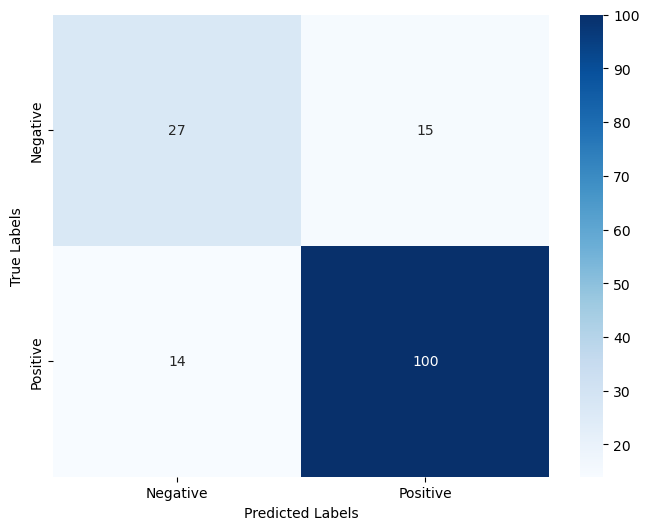

In [ ]:
cm = confusion_matrix(test_labels.cpu().numpy(), test_predictions.argmax(dim=1).cpu().numpy(), labels=[0, 1])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()